<a id='sec0'></a>

# Optimizing n-class word extraction1 : relative difference

The extracted words here will be combined with others extracted in different ways

<a href='#sec1'><b>1. Import and pre-process data</b></a>

<a href='#sec2'><b>2. Frequency Optimization</b></a>
   
<a href='#sec3'><b>3. PCA & LDA</b></a>

In [1]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import importlib as imp
import feature_engineering.frequency_selection as fefs
import myplot.decomposition as mpd

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

Using TensorFlow backend.
Slow version of gensim.models.doc2vec is being used


<a id='sec1'></a>
# 1. Import and pre-process data
(<a href='#sec0'>Back to top</a>)

In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep=r"\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

In [3]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

perdoc_apps = pd.DataFrame(ave_perdoc_apps).fillna(value=0)

In [4]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 350 ms, sys: 4.08 ms, total: 354 ms
Wall time: 355 ms


<a id='sec2'></a>
# 2. Frequency Optimization
- Play with the cutoff frequency parameters
- Use relative difference and fraction_of_docs

(<a href='#sec0'>Back to top</a>)

In [14]:
import feature_engineering.frequency_selection
imp.reload(feature_engineering.frequency_selection)

<module 'feature_engineering.frequency_selection' from '/home/ryohayama/python_current/kaggle_sloan/feature_engineering/frequency_selection.py'>

In [19]:
%%time
# Basic setup & Parameters
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)

min_diffs = [0.5, 0.4, 0.3, 0.2, 0.1]
min_freqs = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
num_iterations = len(min_diffs) * len(min_freqs)

params = []
results = []
counter = 1
print('params=(min_diff, min_freq)')
for i, diff in enumerate(min_diffs):
    for j, freq in enumerate(min_freqs):
        param = (diff, freq)
        rfc_result = fefs.RFC_NClassWords(
                    unclassified_tokenized_docs, fracdocs_update1, y, n_class=8, 
                    doc_type='fraction_of_docs', extract_mode='absolute', 
                    min_difference=diff, min_frequency=freq, verbose=False,
                    vector_type='tfidf', test_size=0.15, random_state=345,
                    rfc=rfc)
        if rfc_result is not None:
            result = (param, rfc_result)
            results.append(result)
            print('%d/%d completed: params=(%.3f, %.3f), accuracy=%.3f, log_loss=%.3f'\
                   % (counter, num_iterations, diff, freq, rfc_result[0], rfc_result[1]))
        else:
            print('%d/%d completed: params=(%.3f, %.3f), No words extracted'\
                   % (counter, num_iterations, diff, freq))
        counter += 1

params=(min_diff, min_freq, min_excl_freq)
ERROR: Absolute difference too high. Lower min_difference
1/30 completed: params=(0.500, 0.600), No words extracted
2/30 completed: params=(0.500, 0.500), No words extracted
3/30 completed: params=(0.500, 0.400), No words extracted
4/30 completed: params=(0.500, 0.300), No words extracted
5/30 completed: params=(0.500, 0.200), No words extracted
6/30 completed: params=(0.500, 0.100), No words extracted
7/30 completed: params=(0.400, 0.600), accuracy=0.365, log_loss=1.791
8/30 completed: params=(0.400, 0.500), accuracy=0.371, log_loss=1.655
9/30 completed: params=(0.400, 0.400), accuracy=0.363, log_loss=1.642
10/30 completed: params=(0.400, 0.300), accuracy=0.363, log_loss=1.642
11/30 completed: params=(0.400, 0.200), accuracy=0.363, log_loss=1.642
12/30 completed: params=(0.400, 0.100), accuracy=0.363, log_loss=1.642
13/30 completed: params=(0.300, 0.600), accuracy=0.547, log_loss=1.244
14/30 completed: params=(0.300, 0.500), accuracy=0.551, l

Examine the result by plotting dependence of scores on parameters

In [27]:
rearranged_result = []
for i in range(len(results)):
    new_result = {}
    new_result['min_diff'] = results[i][0][0]
    new_result['min_freq'] = results[i][0][1]
    new_result['accuracy'] = results[i][1][0]
    new_result['log_loss'] = results[i][1][1]
    rearranged_result.append(new_result)
param_table2 = pd.DataFrame(rearranged_result)

param_table2 = param_table2[['min_diff', 'min_freq', 'accuracy', 'log_loss']]
param_table2.to_csv("./data/nwords_parameterization2.csv", index=False)

In [5]:
param_table2 = pd.read_csv("./data/nwords_parameterization2.csv")

In [6]:
param_table2.head()

,min_diff,min_freq,accuracy,log_loss
0,0.4,0.6,0.364729,1.791261
1,0.4,0.5,0.370741,1.654597
2,0.4,0.4,0.362725,1.642179
3,0.4,0.3,0.362725,1.642179
4,0.4,0.2,0.362725,1.642179


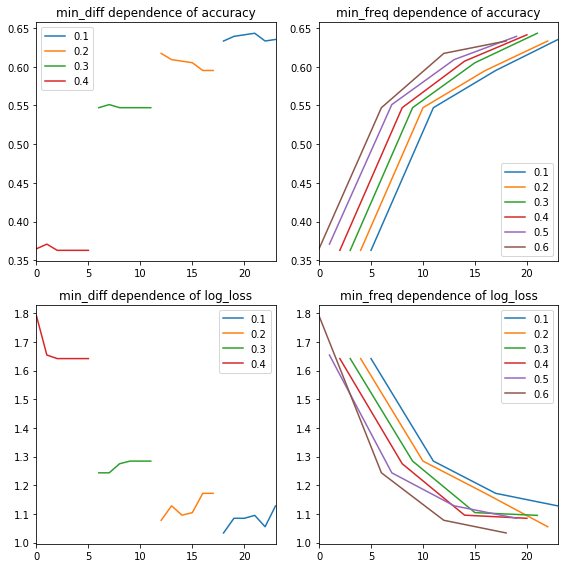

In [7]:
fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2,2, figsize=(8, 8))
param_table2.groupby('min_diff')['accuracy'].plot(ax=ax1, title='min_diff dependence of accuracy', legend=True)
param_table2.groupby('min_diff')['log_loss'].plot(ax=ax4, title='min_diff dependence of log_loss', legend=True)
param_table2.groupby('min_freq')['accuracy'].plot(ax=ax2, title='min_freq dependence of accuracy', legend=True)
param_table2.groupby('min_freq')['log_loss'].plot(ax=ax5, title='min_freq dependence of log_loss', legend=True)
plt.tight_layout()

In [8]:
# Best result in terms of log loss
param_table2[param_table2['log_loss'] == np.min(param_table2['log_loss'])]

,min_diff,min_freq,accuracy,log_loss
18,0.1,0.6,0.633267,1.033943


In [10]:
# Re-run the same function with the above parameters
y = np.array(class_train.Class).astype(int).ravel()
rfc = RandomForestClassifier(n_estimators=200, max_depth=12,
                             n_jobs=8, random_state=33)
validation_result = fefs.RFC_NClassWords(
                    unclassified_tokenized_docs, fracdocs_update1, y, n_class=8, 
                    doc_type='fraction_of_docs', extract_mode='absolute', 
                    min_difference=0.1, min_frequency=0.6, verbose=True,
                    vector_type='tfidf', test_size=0.15, random_state=345,rfc=rfc)

Extracting words...
259 words extracted...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.633
 - Log Loss: 1.034


In [13]:
# Validate with selected features (words)
nclass_words = fefs.getNClassWords(fracdocs_update1, doc_type='fraction_of_docs',
                            mode='absolute', min_frequency=0.6,
                            min_difference=0.1, print_result=False)
select_words = fefs.selectNClassWords(nclass_words, n=8)
validation_result2 = fefs.RFC_CustomWords(unclassified_tokenized_docs, fracdocs_update1, y, 
                                select_words, vector_type='count', test_size=0.15, 
                                random_state=345, verbose=True,rfc=rfc)

259 words selected...
Vectorizating texts...
5 of 3321 entries not covered by the extracted words
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.633
 - Log Loss: 1.034


<a id='sec3'></a>
# 3. PCA & LDA
<a href='#sec0'>Back to top</a>

In [14]:
selectX = validation_result2['feature_matrix']
print(selectX.shape)

(3321, 259)


<b>PCA</b>

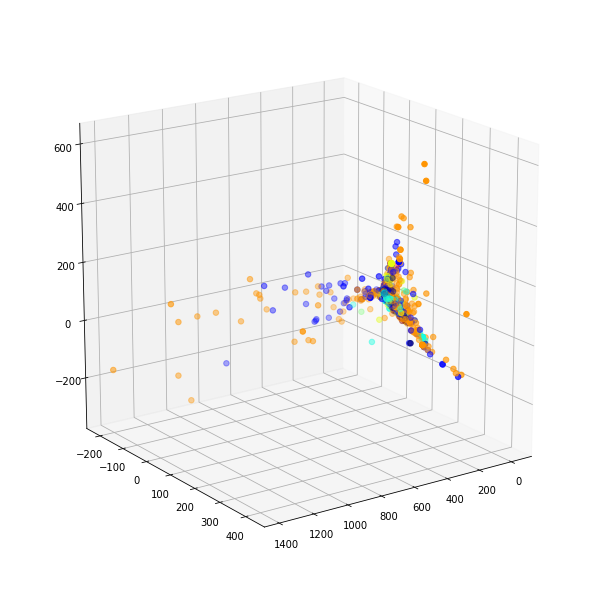

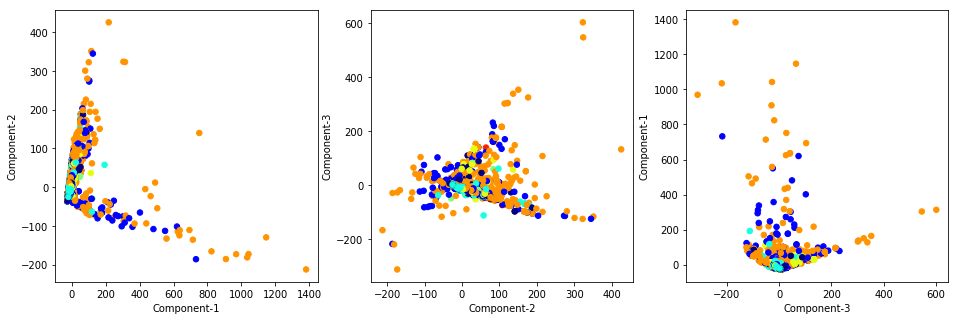

In [15]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'])
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [16]:
%%time
pca = PCA()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)
print(X_test.shape, X_test_pca.shape)

rfc.fit(X_train_pca, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_pca))
lloss = log_loss(y_test, rfc.predict_proba(X_test_pca), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 259) (2822, 259)
(499, 259) (499, 259)
Accuracy 0.603
Log Loss 1.401
CPU times: user 3.11 s, sys: 30.1 ms, total: 3.14 s
Wall time: 950 ms


<b>LDA</b>

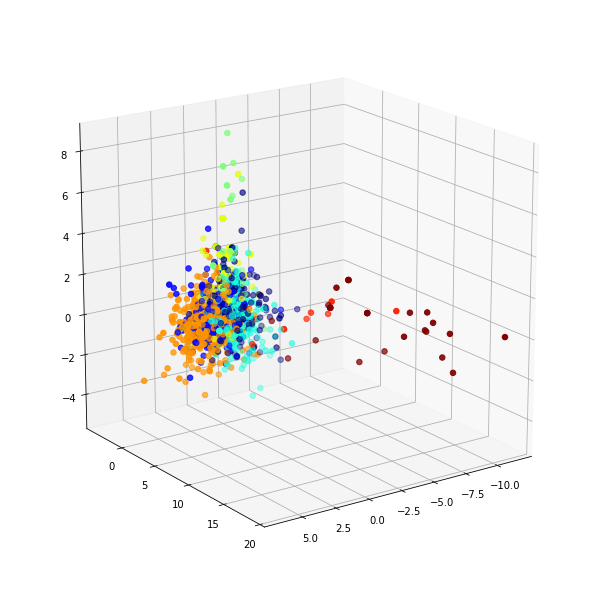

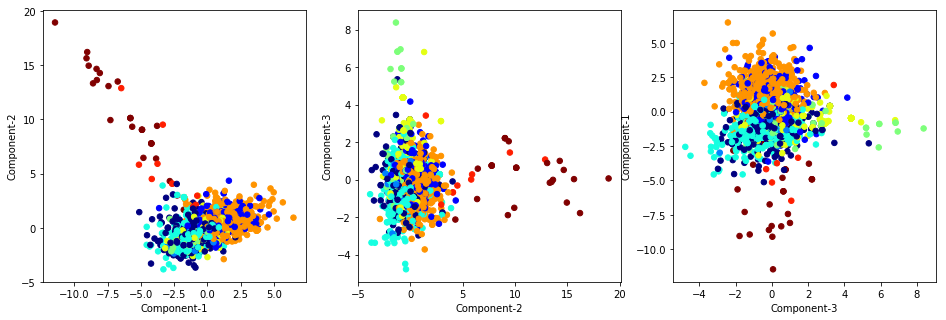

In [17]:
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                y=y, decomposer=LinearDiscriminantAnalysis(n_components=3))
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])

In [18]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(selectX, y, test_size=0.15, random_state=345)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 259) (2822, 8)
(499, 259) (499, 8)
Accuracy 0.595
Log Loss 2.025
CPU times: user 731 ms, sys: 19.1 ms, total: 750 ms
Wall time: 531 ms


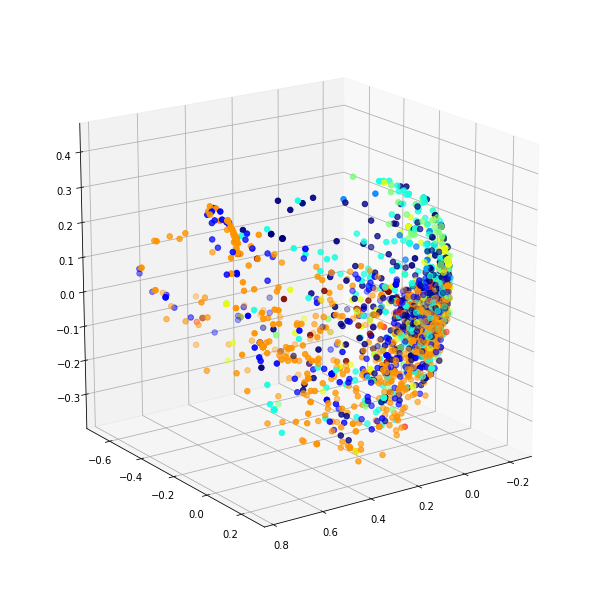

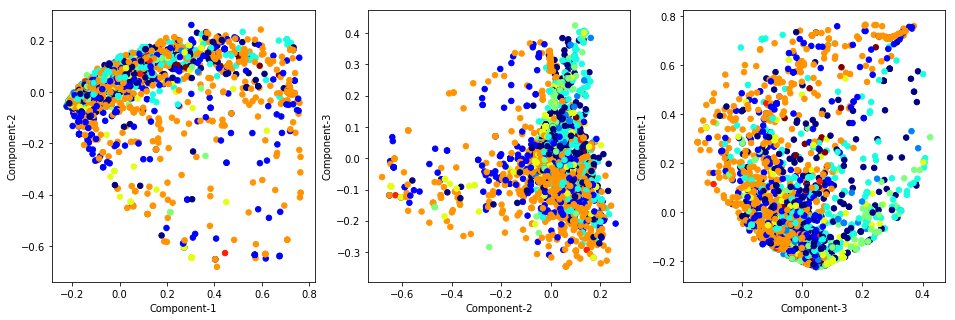

In [33]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel="rbf", gamma=2e-5, n_components=3, n_jobs=8)
decomp_table = mpd.decomposition3D(selectX, class_train['Class'], 
                                y=y, decomposer=kpca)
mpd.decomposition3DPlot(decomp_table, class_train['Class'])
mpd.decomposition2DPlot(decomp_table, class_train['Class'])